In [27]:
# self-define function
from data_cleaning import cleaning_text_MD, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_MD"
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
# nlp
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import spacy 
nlp = spacy.load("en_core_web_lg")
from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/topic_modelling_QA_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])
pd.set_option('display.max_columns', None)

model_df.reset_index(drop=True, inplace=True)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"['number', 'question', 'sense', 'release', 'co...",191,1335,92,6.989529,2.076087
1,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,134.0,1,1,LEGAL -,"Andy Hughes, Exane BNP Paribas. Andy Hughes 1...",Andy Hughes Exane BNP Paribas Andy Hughes T...,question benefit fact chunk par term credit sp...,"['question', 'benefit', 'fact', 'chunk', 'term...",99,663,52,6.696970,1.903846
2,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,318.0,1,1,LEGAL -,"Oliver Steel, Deutsche Bank. Oliver Steel 606...",Oliver Steel Deutsche Bank Oliver Steel Jus...,question surplus profit stage solvency financi...,"['question', 'surplus', 'profit', 'stage', 'so...",37,251,23,6.783784,1.608696
3,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,255.0,1,1,LEGAL -,"Marcus Barnard, Oriel Securities. Marcus Barna...",Marcus Barnard Oriel Securities Marcus Barnard...,question one capital speaker question second s...,"['question', 'capital', 'speaker', 'question',...",54,390,38,7.222222,1.421053
4,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,217.0,1,1,LEGAL -,"Andrew Crean, Autonomous Research LLP. Andrew ...",Andrew Crean Autonomous Research LLP Andrew Cr...,question level reserve transaction transaction...,"['question', 'level', 'reserve', 'transaction'...",21,162,13,7.714286,1.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,163.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Ulrik Zurc...,We will take our next question from Ulrik Zurc...,question line question inﬂation supply chain i...,"['question', 'question', 'inﬂation', 'supply',...",101,694,30,6.871287,3.366667
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"['question', 'market', 'morning', 'question', ...",109,720,31,6.605505,3.516129
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"['question', 'question', 'inﬂation', 'question...",82,563,40,6.865854,2.050000
13274,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"['question', 'morning', 'question', 'claim', '...",77,493,20,6.402597,3.850000


# Tokenize

In [29]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [30]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_15692/458752224.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|██████████| 13276/13276 [04:27<00:00, 49.65it/s]


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",191,1335,92,6.989529,2.076087
1,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,134.0,1,1,LEGAL -,"Andy Hughes, Exane BNP Paribas. Andy Hughes 1...",Andy Hughes Exane BNP Paribas Andy Hughes T...,question benefit fact chunk par term credit sp...,"[question, benefit, fact, chunk, term, credit,...",99,663,52,6.696970,1.903846
2,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,318.0,1,1,LEGAL -,"Oliver Steel, Deutsche Bank. Oliver Steel 606...",Oliver Steel Deutsche Bank Oliver Steel Jus...,question surplus profit stage solvency financi...,"[question, surplus, profit, stage, solvency, f...",37,251,23,6.783784,1.608696
3,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,255.0,1,1,LEGAL -,"Marcus Barnard, Oriel Securities. Marcus Barna...",Marcus Barnard Oriel Securities Marcus Barnard...,question one capital speaker question second s...,"[question, capital, speaker, question, securit...",54,390,38,7.222222,1.421053
4,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,217.0,1,1,LEGAL -,"Andrew Crean, Autonomous Research LLP. Andrew ...",Andrew Crean Autonomous Research LLP Andrew Cr...,question level reserve transaction transaction...,"[question, level, reserve, transaction, transa...",21,162,13,7.714286,1.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,163.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Ulrik Zurc...,We will take our next question from Ulrik Zurc...,question line question inﬂation supply chain i...,"[question, question, inﬂation, supply, chain, ...",101,694,30,6.871287,3.366667
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"[question, market, morning, question, question...",109,720,31,6.605505,3.516129
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"[question, question, inﬂation, question, bit, ...",82,563,40,6.865854,2.050000
13274,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"[question, morning, question, claim, claim, eﬀ...",77,493,20,6.402597,3.850000


In [31]:
# DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# https://cloud.tencent.com/developer/article/1435976

model_df['date'] = pd.to_datetime(model_df['date'])
model_df['year'] = model_df['date'].apply(lambda x: x.year)
model_df['month'] = model_df['date'].apply(lambda x: x.month)
model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# model_df['date'] to str
model_df['date'] = model_df['date'].astype(str)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,year,month,quater,year_quater
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",191,1335,92,6.989529,2.076087,2011,2,1,2011-1
1,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,134.0,1,1,LEGAL -,"Andy Hughes, Exane BNP Paribas. Andy Hughes 1...",Andy Hughes Exane BNP Paribas Andy Hughes T...,question benefit fact chunk par term credit sp...,"[question, benefit, fact, chunk, term, credit,...",99,663,52,6.696970,1.903846,2011,2,1,2011-1
2,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,318.0,1,1,LEGAL -,"Oliver Steel, Deutsche Bank. Oliver Steel 606...",Oliver Steel Deutsche Bank Oliver Steel Jus...,question surplus profit stage solvency financi...,"[question, surplus, profit, stage, solvency, f...",37,251,23,6.783784,1.608696,2011,2,1,2011-1
3,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,255.0,1,1,LEGAL -,"Marcus Barnard, Oriel Securities. Marcus Barna...",Marcus Barnard Oriel Securities Marcus Barnard...,question one capital speaker question second s...,"[question, capital, speaker, question, securit...",54,390,38,7.222222,1.421053,2011,2,1,2011-1
4,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,217.0,1,1,LEGAL -,"Andrew Crean, Autonomous Research LLP. Andrew ...",Andrew Crean Autonomous Research LLP Andrew Cr...,question level reserve transaction transaction...,"[question, level, reserve, transaction, transa...",21,162,13,7.714286,1.615385,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,163.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Ulrik Zurc...,We will take our next question from Ulrik Zurc...,question line question inﬂation supply chain i...,"[question, question, inﬂation, supply, chain, ...",101,694,30,6.871287,3.366667,2022,4,2,2022-2
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"[question, market, morning, question, question...",109,720,31,6.605505,3.516129,2022,4,2,2022-2
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"[question, question, inﬂation, question, bit, ...",82,563,40,6.865854,2.050000,2022,4,2,2022-2
13274,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"[question, morning, question, claim, claim, eﬀ...",77,493,20,6.402597,3.850000,2022,4,2,2022-2


In [32]:
# drop the afternoon, morning, conference, today,lady, gentleman
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i not in [
    'afternoon', 'morning', 'conference','today','lady', 'gentleman', 'presentation',
    'question','answer', 'slide',
    'proÔ¨Åt', 'eÔ¨Äect','proÔ¨Åtability','oÔ¨Ä','diÔ¨Äerent','eÔ¨Éciency','Ô¨Ågure','inÔ¨Çation','Ô¨Çow','conÔ¨Åt',
    'mm', 'mm_mm','guy','sir',' ','host_sir','bb','ty','word', 'year', 'quer','month','period', 'day', 'time','result', 'investor','week', 'update',
    'Ô¨Åre','diÔ¨Äerence','diÔ¨Écult','beneÔ¨Åt', 'business','lot','ratio','rate','quarter', 'number', 'point', 'term', 'thing', 'level', 
    'bit', 'sort', 'reason', 'management', 'fact', 'case', 'area', 'people', 'sense', 'item', 'issue','market'
     ]])
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,year,month,quater,year_quater
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[release, contribution, debate, reinsurance, p...",191,1335,92,6.989529,2.076087,2011,2,1,2011-1
1,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,134.0,1,1,LEGAL -,"Andy Hughes, Exane BNP Paribas. Andy Hughes 1...",Andy Hughes Exane BNP Paribas Andy Hughes T...,question benefit fact chunk par term credit sp...,"[benefit, chunk, credit, spread, gain, transac...",99,663,52,6.696970,1.903846,2011,2,1,2011-1
2,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,318.0,1,1,LEGAL -,"Oliver Steel, Deutsche Bank. Oliver Steel 606...",Oliver Steel Deutsche Bank Oliver Steel Jus...,question surplus profit stage solvency financi...,"[surplus, profit, stage, solvency, financing, ...",37,251,23,6.783784,1.608696,2011,2,1,2011-1
3,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,255.0,1,1,LEGAL -,"Marcus Barnard, Oriel Securities. Marcus Barna...",Marcus Barnard Oriel Securities Marcus Barnard...,question one capital speaker question second s...,"[capital, speaker, security, river, river, riv...",54,390,38,7.222222,1.421053,2011,2,1,2011-1
4,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,217.0,1,1,LEGAL -,"Andrew Crean, Autonomous Research LLP. Andrew ...",Andrew Crean Autonomous Research LLP Andrew Cr...,question level reserve transaction transaction...,"[reserve, transaction, transaction, indication...",21,162,13,7.714286,1.615385,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,163.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Ulrik Zurc...,We will take our next question from Ulrik Zurc...,question line question inﬂation supply chain i...,"[inﬂation, supply, chain, corporate, risk, cla...",101,694,30,6.871287,3.366667,2022,4,2,2022-2
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"[color, environment, reserve, percentage, inﬂa...",109,720,31,6.605505,3.516129,2022,4,2,2022-2
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"[inﬂation, diﬀerent, price, increase, client, ...",82,563,40,6.865854,2.050000,2022,4,2,2022-2
13274,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"[claim, claim, eﬀect, component, claim, column...",77,493,20,6.402597,3.850000,2022,4,2,2022-2


# Word-Length Count

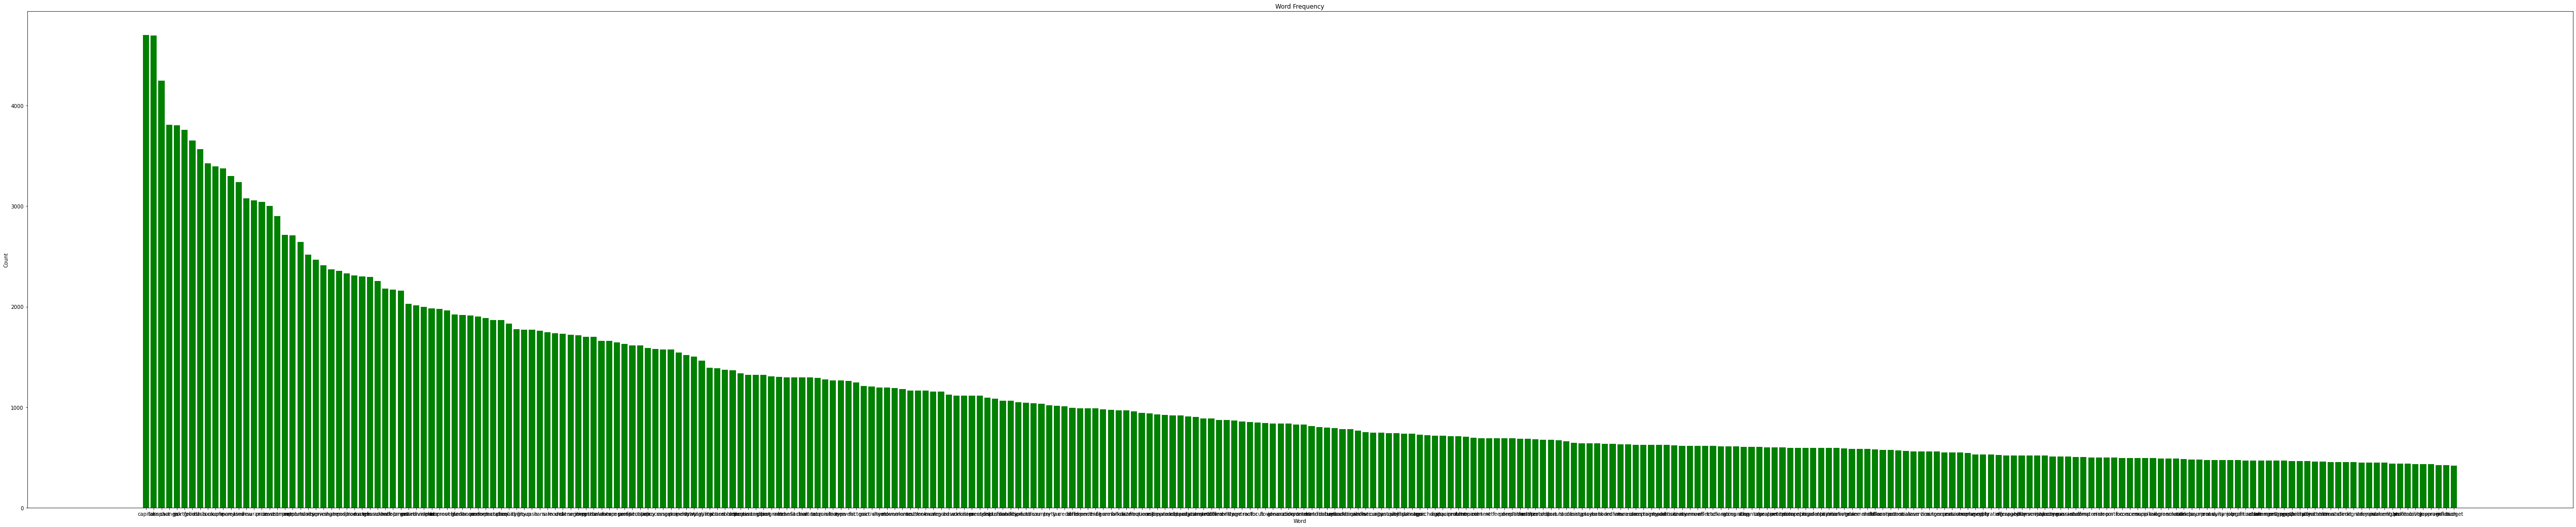

,word,freq
0,capital,4703
1,loss,4696
2,impact,4246
3,change,3811
4,risk,3806
...,...,...
6664,sometmie,1
6665,newswritten,1
6666,immunization,1
6667,stepdown,1


In [33]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

# high frequency words excluding
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(90, 18))
plt.bar(word_fr.word[0:300], word_fr.freq[0:300], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()

# remove 50 most frequent words which is known in this context
word_list = word_fr.head(300)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]
    
word_fr

In [34]:
original_model_df = model_df.copy()

In [35]:
model_df['token'] = mdy_list

In [36]:
# # exclude the rows that the sentence_count is less than 3
# model_df = model_df[model_df['sentence_count']>4]
# # reset the index
# model_df = model_df.reset_index(drop=True)
# model_df_original = model_df.copy()

In [37]:
# # high frequency words excluding
# temp_token = model_df_original['token'] # .apply(remove_brackets)
# docs_tokens = []
# for i in temp_token:
#     docs_tokens.append(i)

# # word frequency
# # explore word frequencies
# word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
# word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# # visualize word frequencies
# # figure size
# fig = plt.figure(figsize=(90, 18))
# plt.bar(word_fr.word[0:150], word_fr.freq[0:150], color='green')
# plt.xlabel("Word")
# plt.ylabel("Count")
# plt.title("Word Frequency")
# plt.show()


# # remove 50 most frequent words which is known in this context
# word_list = word_fr.head(150)['word'].to_list()
# mdy_list, tmp=[],[]
# for review in docs_tokens:
#     for word in review:
#         if word not in word_list:
#             tmp.append(word)
#     mdy_list.append(tmp)
#     tmp=[]

# model_df['token'] = mdy_list
# word_fr

In [38]:
# # DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# # https://cloud.tencent.com/developer/article/1435976

# model_df['date'] = pd.to_datetime(model_df['date'])
# model_df['year'] = model_df['date'].apply(lambda x: x.year)
# model_df['month'] = model_df['date'].apply(lambda x: x.month)
# model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
# model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# # model_df['date'] to str
# model_df['date'] = model_df['date'].astype(str)
# model_df

In [39]:
test_df = model_df.copy()
date_list = test_df['year_quater'].unique().tolist()
# if the date_list == test_df['date'], append to the dtm_list
dtm_token_list = []
dtm_token_df = []
dtm_df = pd.DataFrame()
for date in date_list:
    tmp_df = test_df[test_df['year_quater']==date]

    tmp_token_list = tmp_df['token'].to_list()
    for i in tmp_token_list:
        for k in i:
            dtm_token_list.append(k)
    dtm_token_df.append(dtm_token_list)
    dtm_token_list = []
    dtm_df['year_quater'] = date_list
dtm_df['token'] = dtm_token_df
# dtm_df drop the row 45
dtm_df = dtm_df.drop(45)
dtm_df = dtm_df.drop(44)
dtm_df = dtm_df.reset_index(drop=True)
dtm_df

,year_quater,token
0,2011-1,"[debate, phase, nonlife, triangle, tomorrow, t..."
1,2011-2,"[participation, reinstatement, quota, regime, ..."
2,2011-3,"[hearing, eurm, eurm, goodwill, goodwill, desc..."
3,2011-4,"[explanation, tornado, close, goodwill, impair..."
4,2012-1,"[downturn, economy, recession, crisis, underwr..."
5,2012-2,"[bunch, flood, certainty, variability, laughte..."
6,2012-3,"[longevity, transition, stad, clarification, s..."
7,2012-4,"[ground, ﬁgure, saving, dialogue, behavior, aﬀ..."
8,2013-1,"[surprise, conversion, pick, certificate, logi..."
9,2013-2,"[roe, thinking, certainty, analysis, teen, tee..."


# Docs_tokens

In [40]:
# https://github.com/bab2min/tomotopy
# https://bab2min.github.io/tomotopy/v0.12.3/en/#tomotopy.DTModel
# https://notebook.community/pombredanne/gensim/docs/notebooks/ldaseqmodel

In [41]:
# recrate again for getting the docs_tokens
temp_token_dtm = dtm_df['token'] # .apply(remove_brackets)
docs_tokens_dtm = []
for i in temp_token_dtm:
    docs_tokens_dtm.append(i)
len(docs_tokens_dtm)

44

# docs_phrased

In [42]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram_dtm = Phrases(                              
    docs_tokens_dtm,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram_dtm = Phrases(                             
    bigram_dtm[docs_tokens_dtm],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased_dtm = [trigram_dtm[bigram_dtm[line]] for line in docs_tokens_dtm]
len(docs_tokens_dtm)

44

# corpus

In [43]:
corpus_dtm = tp.utils.Corpus() 
for i in range(len(docs_tokens_dtm)):
    # corpus_dtm.add_doc with timepoint
    corpus_dtm.add_doc(words=docs_tokens_dtm[i], timepoint=i) # dtm_df['date'][i]
print(len(corpus_dtm))

44


# model base on the topic number we select (without time series)

In [52]:
best_mdl = tp.DTModel(
    # tw= TermWeight.ONE, # term weighting scheme in TermWeight. The default value is TermWeight.ONE
    # min_cf=0, # minimum collection frequency of words
    # min_df=0, # minimum document frequency of words
    # rm_top=0, # remove top frequency words
    # transform=None, # transformation of the corpus
    k=14,
    t = len(corpus_dtm),
    corpus=corpus_dtm,
    seed = 1
    )


for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -6.891181439585579
Iteration: 10	Log-likelihood: -6.877297107782789
Iteration: 20	Log-likelihood: -6.863032094541854
Iteration: 30	Log-likelihood: -6.844870429922
Iteration: 40	Log-likelihood: -6.811337160566455
Iteration: 50	Log-likelihood: -6.763137730462274
Iteration: 60	Log-likelihood: -6.720357027600318
Iteration: 70	Log-likelihood: -6.664442737119772
Iteration: 80	Log-likelihood: -6.609480218384293
Iteration: 90	Log-likelihood: -6.546124522790914


In [53]:
wt = pd.DataFrame()
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，with required argument 'timepoint' (pos 2)
for k in range(best_mdl.k):
    words, probs, timepoints = [], [], []
    for t in range(len(corpus_dtm)):
        for word, prob in best_mdl.get_topic_words(k ,timepoint=t):
            timepoints.append(t)
            words.append(word)
            probs.append(prob)
        tmp = pd.DataFrame(
            {
                "word": words,
                "prob": np.round(probs, 3),
                "timepoint": timepoints,
                "k": np.repeat(k, len(words)),
                "sort": np.arange(0, len(words)),
            }
        )
    words, probs, timepoints = [], [], []
    wt = wt.append(tmp)
    del tmp

wt

,word,prob,timepoint,k,sort
0,hedge,0.010,0,0,0
1,injury,0.010,0,0,1
2,trajectory,0.010,0,0,2
3,scheme,0.007,0,0,3
4,energy,0.007,0,0,4
...,...,...,...,...,...
435,confidence,0.004,43,13,435
436,shape,0.004,43,13,436
437,footprint,0.004,43,13,437
438,project,0.003,43,13,438


In [54]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,timepoint
0,0.084735,0.085903,0.055536,0.078311,0.073639,0.057288,0.063128,0.082399,0.081231,0.081815,0.064296,0.053200,0.055536,0.082983,0
1,0.085096,0.060020,0.067106,0.075283,0.081280,0.062745,0.062745,0.058384,0.074738,0.084006,0.074193,0.069287,0.069832,0.075283,1
2,0.058021,0.075135,0.060782,0.069615,0.065198,0.082312,0.076239,0.069615,0.076239,0.065198,0.077343,0.061886,0.079552,0.082864,2
3,0.058109,0.065981,0.094519,0.059093,0.071393,0.074838,0.071393,0.071393,0.081726,0.054172,0.069917,0.072870,0.060077,0.094519,3
4,0.066984,0.068166,0.076435,0.099275,0.054777,0.063834,0.061471,0.075254,0.075648,0.065015,0.060684,0.088249,0.059108,0.085099,4
5,0.062452,0.054274,0.074447,0.081534,0.073629,0.065996,0.065996,0.059181,0.070903,0.075264,0.068449,0.093801,0.077173,0.076900,5
6,0.078871,0.068614,0.062675,0.069154,0.083729,0.050799,0.065914,0.068614,0.092367,0.063755,0.077251,0.084269,0.066994,0.066994,6
7,0.074989,0.088815,0.081902,0.080811,0.056797,0.057888,0.065893,0.072078,0.088451,0.070623,0.065529,0.074625,0.049884,0.071714,7
8,0.087385,0.068800,0.082553,0.064340,0.062110,0.062853,0.074376,0.063968,0.070659,0.068428,0.069544,0.076606,0.073632,0.074747,8
9,0.058217,0.093917,0.064682,0.066650,0.064120,0.066369,0.064963,0.060466,0.080986,0.071710,0.063558,0.073396,0.074802,0.096166,9


In [55]:
# save td to csv
td.to_csv('./main_df_output/QA_DTM_td_all_time.csv', index=False) 
wt.to_csv('./main_df_output/QA_DTM_wt_all_time.csv', index=False)

In [56]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=td.columns,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='All Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

# save the figure to html
fig.write_html('./main_df_output/QA_DTM_topic_plot.html')

In [60]:
test = wt[wt['k']==0]
time_list = [11]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

,0,8,1,3,4,6,9,2,5,7
word,buffer,segmentation,conversation,hedge,layer,proposition,transition,energy,loan,repurchase
prob,0.006,0.006,0.004,0.004,0.004,0.004,0.004,0.003,0.003,0.003


# Early Time

In [40]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_early = td[td['timepoint']<=15]

import plotly.express as px
fig = px.line(td_early, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Early Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [25]:
# - 1 > timep 9
# - 3 > timep 10
# - 4 > timep 13
# - 5 > timep 14
# - 7 > timep 8, 11
# - 8 > timep 5

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_9 = topic_1[topic_1['timepoint']==9]
# concat
topic_1_concate = topic_1_9.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3 = wt[wt['k']==2] # start with 0
# select timepoint
topic_3_9 = topic_3[topic_3['timepoint']==10]
# concat
topic_3_concate = topic_3_9.copy()
topic_3_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_13 = topic_4[topic_4['timepoint']==13]
# concat
topic_4_concate = topic_4_13.copy()
topic_4_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5= wt[wt['k']==4] # start with 0
# select timepoint
topic_5_14 = topic_5[topic_5['timepoint']==14]
# concat 
topic_5_concat = topic_5_14.copy()
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_8 = topic_7[topic_7['timepoint']==8]
topic_7_11 = topic_7[topic_7['timepoint']==11]
# concat 
topic_7_concat = pd.concat([topic_7_8, topic_7_11], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_5 = topic_8[topic_8['timepoint']==5]
# concat
topic_8_concate = topic_8_5.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)

In [26]:
# concat
topic_all_early = pd.concat([topic_1_concate, topic_3_concate, topic_4_concate, topic_5_concat, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_early = topic_all_early.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_early.sort_values(by='prob', ascending=False, inplace=True)
topic_all_early.T

,36,32,2,3,1,23,22,28,4,13,38,33,24,31,17,39,15,14,26,34,10,9,8,7,6,27,20,11,35,37,25,21,29,30,19,18,16,12,5,0
word,stock,scheme,annuity,auto,agent,platform,pension,rating,bank,fee,transcript,security,player,respect,investor,weather,guarantee,government,projection,size,competitor,competition,charge,channel,capacity,protection,operation,datum,space,structure,problem,option,relationship,requirement,motor,measure,idea,employee,capability,adtage
prob,0.007333,0.005,0.00475,0.004,0.004,0.003667,0.003667,0.0035,0.0032,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.00275,0.00275,0.0025,0.0025,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


# Middle Time

In [39]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_middle = td[td['timepoint']>15]
td_middle = td_middle[td_middle['timepoint']<=30]

import plotly.express as px
fig = px.line(td_middle, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Middle Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [35]:
# - 1 > timep 19
# - 3 > timep 24, 25
# - 4 > timep 16, 22, 23
# - 5 > timep 18
# - 7 > timep 20, 26, 27, 29, 30
# - 8 > timep 28

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_19 = topic_1[topic_1['timepoint']==19]
# concat
topic_1_concate = topic_1_19.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_24 = topic_3[topic_3['timepoint']==24]
topic_3_25 = topic_3[topic_3['timepoint']==25]
# concat 
topic_3_concat = pd.concat([topic_3_24, topic_3_25], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4= wt[wt['k']==3] # start with 0
# select timepoint
topic_4_16 = topic_4[topic_4['timepoint']==16]
topic_4_22 = topic_4[topic_4['timepoint']==22]
topic_4_23 = topic_4[topic_4['timepoint']==23]
# concat 
topic_4_concat = pd.concat([topic_4_16, topic_4_22, topic_4_23], ignore_index=True)
topic_4_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5 = wt[wt['k']==4] # start with 0
# select timepoint
topic_5_18 = topic_5[topic_5['timepoint']==18]
# concat
topic_5_concate = topic_5_18.copy()
topic_5_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_20 = topic_7[topic_7['timepoint']==20]
topic_7_26 = topic_7[topic_7['timepoint']==26]
topic_7_27 = topic_7[topic_7['timepoint']==27]
topic_7_29 = topic_7[topic_7['timepoint']==29]
topic_7_30 = topic_7[topic_7['timepoint']==30]
# concat 
topic_7_concat = pd.concat([topic_7_20, topic_7_26, topic_7_27, topic_7_29, topic_7_30], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_28 = topic_8[topic_8['timepoint']==28]
# concat
topic_8_concate = topic_8_28.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)

In [36]:
# concat
topic_all_middle = pd.concat([topic_1_concate, topic_3_concat, topic_4_concat, topic_5_concate, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_middle = topic_all_middle.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_middle.sort_values(by='prob', ascending=False, inplace=True)
topic_all_middle.T

,47,36,24,28,49,10,32,58,50,60,20,54,8,6,61,52,35,41,1,33,53,55,37,9,7,4,3,59,2,16,43,44,0,45,46,48,51,56,57,42,31,40,39,5,11,12,13,14,15,17,18,19,21,22,23,25,26,29,38,62,27,30,34
word,rule,platform,inflation,meeting,sensitivity,car,motor,technology,service,unwriter,fee,state,capability,board,vote,solution,pension,regard,agent,operation,spread,stock,pner,capacity,buyback,bank,auto,transcript,annuity,datum,relationship,remittance,adjustment,report,requirement,scale,size,structure,synergy,regulator,mortgage,quality,proﬁt,bb,casualty,competitor,condition,contract,contribution,duration,energy,entity,frequency,guarantee,hand,investor,item,member,protection,weather,marketplace,mortality,opinion
prob,0.007,0.0055,0.005333,0.005,0.004167,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003667,0.003667,0.003667,0.003667,0.0036,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.003333,0.003273,0.00325,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002,0.002,0.002


# Recent Time

In [43]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td_recent = td[td['timepoint']>30]

import plotly.express as px
fig = px.line(td_recent, x="timepoint", y=['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Recent Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()


In [44]:
# - 1 > timep 33
# - 3 > timep 31, 43
# - 4 > timep 45
# - 5 > timep 32, 34
# - 7 > timep 36, 37, 39, 40 
# - 8 > timep 42

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_33 = topic_1[topic_1['timepoint']==33]
# concat
topic_1_concate = topic_1_33.copy()
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_31 = topic_3[topic_3['timepoint']==31]
topic_3_43 = topic_3[topic_3['timepoint']==43]
# concat 
topic_3_concat = pd.concat([topic_3_31, topic_3_43], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_45 = topic_4[topic_4['timepoint']==45]
# concat
topic_4_concate = topic_4_45.copy()
topic_4_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5= wt[wt['k']==4] # start with 0
# select timepoint
topic_5_32 = topic_5[topic_5['timepoint']==32]
topic_5_34 = topic_5[topic_5['timepoint']==34]
# concat 
topic_5_concat = pd.concat([topic_5_32, topic_5_34], ignore_index=True)
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_7
topic_7= wt[wt['k']==6] # start with 0
# select timepoint
topic_7_36 = topic_7[topic_7['timepoint']==36]
topic_7_37 = topic_7[topic_7['timepoint']==37]
topic_7_39 = topic_7[topic_7['timepoint']==39]
topic_7_40 = topic_7[topic_7['timepoint']==40]
# concat 
topic_7_concat = pd.concat([topic_7_36, topic_7_37, topic_7_39, topic_7_40], ignore_index=True)
topic_7_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_8
topic_8 = wt[wt['k']==7] # start with 0
# select timepoint
topic_8_42 = topic_8[topic_8['timepoint']==42]
# concat
topic_8_concate = topic_8_42.copy()
topic_8_concate.sort_values(by='prob', ascending=False, inplace=True)


In [45]:
# concat
topic_all_recent = pd.concat([ topic_1_concate, topic_3_concat, topic_4_concat, topic_5_concat, topic_7_concat, topic_8_concate], ignore_index=True)
# groupby word and get the average of prob
topic_all_recent = topic_all_recent.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_recent.sort_values(by='prob', ascending=False, inplace=True)
topic_all_recent.T

,47,23,27,63,5,15,43,17,24,51,29,0,10,37,50,49,54,41,60,62,36,32,31,28,64,65,16,9,21,6,58,33,12,59,1,53,2,34,61,4,11,3,57,56,55,7,52,8,46,48,25,30,20,19,35,18,38,39,40,14,42,13,44,45,22,26
word,rule,fee,inflation,vote,board,coverage,report,datum,frequency,service,inﬂation,agent,casualty,platform,sensitivity,scenario,space,regulator,travel,unwriter,pension,mortality,meeting,interruption,week,worker,crisis,car,estate,buyback,synergy,mortgage,condition,transcript,annuity,solution,approach,motor,uncertainty,bank,competitor,audit,stock,statement,spread,capability,severity,capacity,revenue,scale,guarantee,item,duration,diﬀerent,operation,digit,pner,protection,quality,contribution,relationship,contract,requirement,respect,estimate,hand
prob,0.007,0.007,0.006714,0.005,0.005,0.005,0.005,0.004667,0.004667,0.0045,0.0045,0.0045,0.004333,0.004333,0.0042,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003833,0.0035,0.0035,0.0035,0.003444,0.003333,0.003333,0.003333,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002667,0.002667


In [46]:
# topic_all_recently to csv
topic_all_recent.to_csv('./main_df_output/QA_topic_all_recently.csv')
topic_all_early.to_csv('./main_df_output/QA_topic_all_early.csv')
topic_all_middle.to_csv('./main_df_output/QA_topic_all_middle.csv')